In [1]:
import tensorflow as tf
import numpy as np
from tensorflow_vgg.utils import load_image, print_prob

def rand_variable(shape, stddev=0.1):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)

In [2]:
from tensorflow_vgg.vgg16 import Vgg16

In [3]:
image = rand_variable([1, 224, 224, 3])
vgg = Vgg16()
with tf.name_scope('content_vgg'):
    vgg.build(image)

/home/nparrott/notebooks/tensorflow_vgg/../../data/vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [4]:
session = tf.Session(config=tf.ConfigProto(gpu_options=(tf.GPUOptions(per_process_gpu_memory_fraction=0.7))))

In [5]:
# style transfer:
style_image = load_image('../data/starrynight.jpg').reshape((1,224,224,3))
content_image = load_image('../data/lampbear.jpg').reshape((1,224,224,3))

In [19]:
content_layer = vgg.conv4_3
style_layers = [vgg.conv1_1, vgg.conv1_2, vgg.conv2_2, vgg.conv3_3]

In [20]:
# get content layer activations:
session.run(image.assign(content_image))
content_layer_activations = session.run(content_layer)

In [21]:
# get style layer activations:
session.run(image.assign(style_image))

def style_gram(layer):
    _, height, width, channels = [d.value for d in layer.get_shape()]
    features = tf.reshape(layer, [-1, channels])
    gram = tf.matmul(tf.transpose(features), features) / (width * height * channels)
    return gram

style_grams = session.run([style_gram(layer) for layer in style_layers])

In [22]:
CONTENT_WEIGHT = 0.7
STYLE_WEIGHT = 0.3

content_loss = 2 * tf.nn.l2_loss(content_layer - tf.constant(content_layer_activations))
style_loss = tf.add_n([2 * tf.nn.l2_loss(target - style_gram(layer)) for layer, target in zip(style_layers, style_grams)])
loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss
# need to add "total variation denoising"????

In [23]:
# we need to initialize the adamoptimizer 
learning_rate = tf.placeholder(tf.float32, shape=[])
stylize_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Step: 0; loss: 9544944640.0
Step: 10; loss: 4622188544.0
Step: 20; loss: 1894735232.0
Step: 30; loss: 997010944.0
Step: 40; loss: 679491968.0
Step: 50; loss: 543178880.0
Step: 60; loss: 469794624.0
Step: 70; loss: 420274432.0
Step: 80; loss: 388179552.0
Step: 90; loss: 392164704.0
Step: 100; loss: 386184704.0
Step: 110; loss: 338851168.0
Step: 120; loss: 323942208.0
Step: 130; loss: 315517440.0
Step: 140; loss: 310193120.0


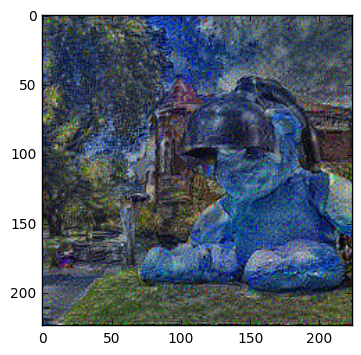

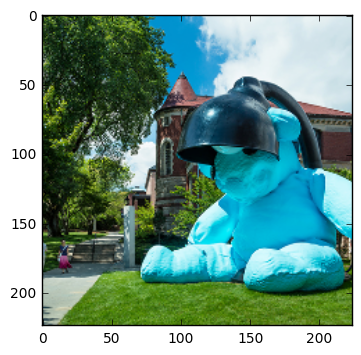

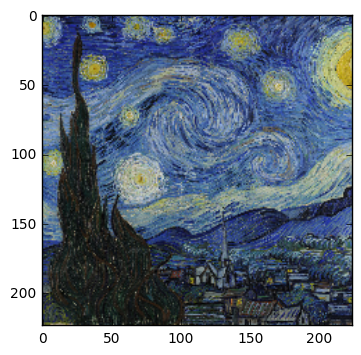

In [26]:
%matplotlib inline

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
# session.run(image.assign(content_image)) # should we start with random noise instead?
initial_img = np.abs(np.random.normal(size=[1,224,224,3], scale=np.std(content_image) * 0.2))
session.run(image.assign(initial_img)) # init with random noise

for step in xrange(150):
    lr = 0.1
    if step > 100:
        lr = 0.01
    _, loss_ = session.run([stylize_op, loss], feed_dict={learning_rate: lr})
    if step % 10 == 0:
        print 'Step: {}; loss: {}'.format(step, loss_)
        
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(session.run(image).reshape((224,224,3)).clip(0,1))
plt.figure()
plt.imshow(content_image.reshape(224,224,3))
plt.figure()
plt.imshow(style_image.reshape(224,224,3))

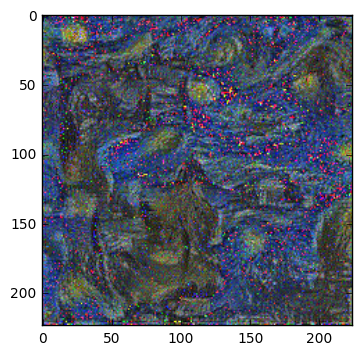

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(session.run(image).reshape((224,224,3)))